The burst analysis is based on the work done by Jonas S. Juul; "Bursty growth of networks".

In our Wiki data we have the last revision for each year which will create a problem as we might only get the December bursts. We propose instead that we take the timestamp from when the article was first created and use the last revision of the same year as the node's edges and perform the same analysis as done in his article.

Whenever a node, $v_t$ is added to the graph at time $t$, we check if the $v_t$ shares neighbours with $v_{t-1}$. If yes, we append the number of shared neighbours to a list, $\textbf{l}$, and $0$ otherwise. We then take the sum of $\textbf{l}$.

We then permute the node creation timestamps and do the same test. This is done $n$ times and by the end we will have a distribution of sums over $\textbf{l}$. Here the null-hypothesis is that the true sum of $\textbf{l}$ does not deviate from the sum of $\textbf{l}$ from randomly permuted timestamps.

In [54]:
import os
import io
import re
import networkx as nx
import netwulf as nw 
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
df_marvel = pd.read_csv("files/marvel.csv", index_col=0, encoding='utf8')
df_marvel = df_marvel[df_marvel["WikiLink"].notna()]
df_dc = pd.read_csv("files/dc.csv", index_col=0, encoding='utf8')
df_dc = df_dc[df_dc["WikiLink"].notna()]

df_marvel['universe'] = 'Marvel'
df_dc['universe'] = 'DC'

df_comics = pd.concat([df_marvel, df_dc], ignore_index=True, axis=0)
df_comics['creation'] = np.empty(len(df_comics),dtype="<U10")

In [47]:
import requests
import datetime
import json
from tqdm import tqdm
import numpy as np
from urllib import request
from urllib.parse import quote
import os
import pickle

BASE_URL = "http://en.wikipedia.org/w/api.php"

for idx, row in tqdm(df_comics.iloc[:].iterrows()):
    wikilink = row["WikiLink"]
    character_name = row["CharacterName"]
    creations = []
    for link in wikilink.split('|'):
        
        parameters = { 'action': 'query',
                   'format': 'json',
                   #'continue': '',
                   'titles': link,
                   'prop': 'revisions',
                   'rvprop': 'timestamp',
                   'rvdir': 'newer',
                   'redirects': 'yes', #Took me a while to find this. Now we get pages
                      #that we should be redirected to! (Achebe (comics) redirects to
                      #achebe (character)!)
                   'rvlimit': '1'}

        wp_call = requests.get(BASE_URL, params=parameters)
        response = wp_call.json()
        try:
            creation = response['query']['pages'][list(response['query']['pages'].keys())[0]]['revisions'][0]['timestamp']
            creations.append(creation)
        except:
            pass
    try:
        
        creations = min(creations)
        df_comics['creation'][idx] = creations
    except:
        df_comics['creation'][idx] = 'Unknown'

        

2303it [11:08,  3.44it/s]


In [49]:
df_comics.to_csv('df_with_creation.csv')

In [56]:
df_comics = pd.read_csv('df_with_creation.csv', index_col='Unnamed: 0')

In [57]:
creations = dict(zip(df_comics['WikiLink'], df_comics['creation']))

In [58]:
graphs = {}
for key in np.arange(2001,2023,1):
    graphs[key] = nx.read_gml(f'graphs/DG_{key}')

In [59]:
#set node attributes:
for key in graphs.keys():
    nx.set_node_attributes(graphs[key], creations, 'creation')

In [60]:
names_list_sorted = pd.DataFrame(df_comics.sort_values('creation')[['WikiLink','creation']])
names_list_sorted = names_list_sorted.reset_index()

In [61]:
import numpy as np
def permute_names(list_of_chars, seed=0):
    names = np.array(list_of_chars[['WikiLink','creation']])
    np.random.seed(seed)
    return pd.DataFrame(data = np.random.permutation(names), columns = ['WikiLink','creation'])

In [62]:
def check_neighbours(G, v_t1, v_t2):
    intersect = len(set(list(G.neighbors(v_t1))+list(G.predecessors(v_t1))).intersection(list(G.neighbors(v_t2))+list(G.predecessors(v_t2))))
    union = len(set(list(G.neighbors(v_t1))+list(G.predecessors(v_t1))).union(list(G.neighbors(v_t2))+list(G.predecessors(v_t2))))
    if intersect/union == 1:
        return None
    else:
        return intersect

In [76]:
def get_summed_list(G_dict, list_of_chars):
    list_to_sum = []
    for idx, node in list_of_chars.iterrows():
        if idx == len(list_of_chars)-1:
            return sum(list_to_sum)
        v_t1 = node['WikiLink']
        if node['creation'] != 'Unknown':
            G = G_dict[int(node['creation'][:4])]
        else:
            G = G_dict[list(graphs.keys())[-1]]
        try:
            if list(G.neighbors(v_t1))+list(G.predecessors(v_t1)) == []:
                continue
        except:
            continue
        count = 1
        while True:
            try:
                v_t2 = list_of_chars.iloc[idx+count]['WikiLink']
            except IndexError:
                return sum(list_to_sum)
            try:
                nincommon = check_neighbours(G, v_t1, v_t2)
            except:
                count += 1
                continue
            if nincommon == None:
                count += 1
            else:
                list_to_sum.append(nincommon)
                #idx += count
                break
    #return sum(list_to_sum)
#Need to skip nodes that are not in graph

In [72]:
list(graphs.keys())[-1]

2022

In [77]:
# do permutation test:
perm_sums = []
for seed in tqdm(range(1000)):
    permuted = permute_names(list_of_chars=names_list_sorted, seed=seed)
    perm_sums.append(get_summed_list(graphs,permuted))

100%|██████████| 1000/1000 [03:15<00:00,  5.11it/s]


In [78]:
true_sum = get_summed_list(graphs, names_list_sorted)

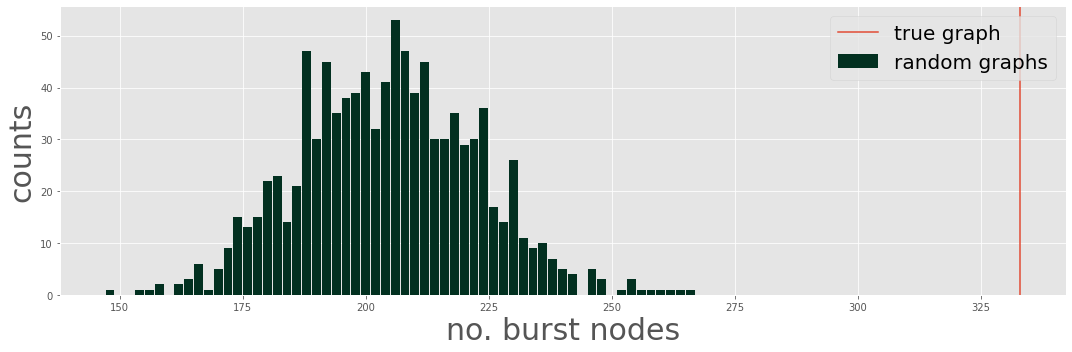

In [84]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,5))

bins = np.arange(min(perm_sums), max(perm_sums), 2)


hist, edges = np.histogram(perm_sums, bins=bins)

x = (edges[1:]+edges[:-1])/2
width = bins[1] - bins[0]

ax.bar(x, hist,color='#023020', width=width*0.897, label='random graphs')
ax.axvline(true_sum, label='true graph')




ax.set_xlabel("no. burst nodes", fontsize=30)

ax.set_ylabel("counts", fontsize=30)

ax.legend(fontsize=20, loc='upper right')
plt.tight_layout()
plt.savefig('node_burst_detection.png')
plt.show()

In [27]:
def same_coms(G, list_of_chars):
    list_to_sum = []
    for idx, node in list_of_chars.iterrows():
        if idx == len(list_of_chars)-1:
            return sum(list_to_sum)
        v_t1 = node['WikiLink']
        try:
            if list(G.neighbors(v_t1)) == []:
                continue
        except:
            continue
        count = 1
        while True:
            try:
                v_t2 = list_of_chars.iloc[idx+count]['WikiLink']
            except IndexError:
                return sum(list_to_sum)
            try:
                nincommon = check_neighbours(G, v_t1, v_t2)
            except:
                count += 1
                continue
            if nincommon == None:
                count += 1
            else:
                list_to_sum.append(nincommon)
                #idx += count
                break

In [28]:
same_coms(graphs[2022], names_list_sorted)

1591

In [ ]:
#plt.style.use('ggplot')
#plt.scatter(np.arange(len(sorted_ts_dict)), same_coms(sorted_ts_dict), marker='x', s=0.5)